In [1]:
import numpy as np
import pandas as pd
from matplotlib import rcParams
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# 设置 matplotlib 风格
config = {
    "mathtext.fontset": 'stix',
    "font.family": 'serif',
    "font.serif": ['SimHei'],
    "font.size": 10,
    'axes.unicode_minus': False
}
rcParams.update(config)

逻辑回归

In [3]:
#逻辑回归类
class LogisticRegression:
    def __init__(self, alpha=0.001, iters=10000):
        self.alpha = alpha
        self.iters = iters
        self.W = None
        self.train_losses = None
        self.val_losses = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def computeCost(self, X, y):
        P = self.sigmoid(X.dot(self.W))
        loss = -np.sum(y * np.log(P) + (1 - y) * np.log(1 - P)) / X.shape[0]
        return loss, P

    def gradientDescent(self, X, y):
        error = self.sigmoid(X.dot(self.W)) - y
        grad = np.dot(X.T, error) / X.shape[0]
        self.W -= self.alpha * grad

    def fit(self, X_train, y_train, X_val, y_val):
        self.W = np.zeros(X_train.shape[1])
        self.train_losses = []
        self.val_losses = []

        for i in range(self.iters):
            self.gradientDescent(X_train, y_train)
            train_loss, _ = self.computeCost(X_train, y_train)
            val_loss, _ = self.computeCost(X_val, y_val)
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

    def predict(self, X):
        prob = self.sigmoid(X.dot(self.W))
        y_hat = prob >= 0.5
        return y_hat, prob



In [4]:
# 读取数据
path = 'C:/Users/Asus/Downloads/ex2data1.txt'
data = pd.read_csv(path)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [5]:
# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 重复K折划分
kf = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

alpha = 0.001
iters = 10000

In [6]:
# 初始化模型
precision_all = []
recall_all = []
f1_all = []
auc_all = []
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)
train_losses_all = []
val_losses_all = []

In [7]:
# 进行K折交叉验证
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # 添加截距项
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    # 初始化逻辑回归模型
    log_reg = LogisticRegression(alpha=alpha, iters=iters)
    log_reg.fit(X_train, y_train, X_test, y_test)

    # 预测并评估模型
    y_pred, _ = log_reg.predict(X_test)
    precision_all.append(precision_score(y_test, y_pred))
    recall_all.append(recall_score(y_test, y_pred))
    f1_all.append(f1_score(y_test, y_pred))

    # ROC曲线和AUC
    fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict(X_test)[1])
    auc_all.append(auc(fpr, tpr))
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    mean_tpr += interp_tpr

    # 记录训练过程中的损失
    train_losses_all.append(log_reg.train_losses)
    val_losses_all.append(log_reg.val_losses)


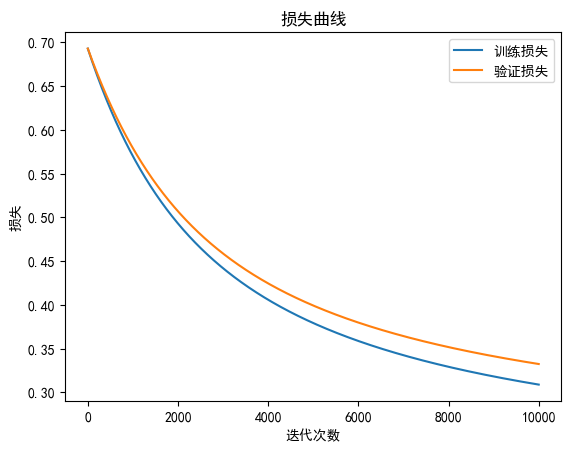

In [8]:
# 计算平均训练集和验证集损失
mean_train_losses = np.mean(np.array(train_losses_all), axis=0)
mean_val_losses = np.mean(np.array(val_losses_all), axis=0)

# 绘制平均损失曲线
plt.figure()
plt.plot(range(len(mean_train_losses)), mean_train_losses, label='训练损失')
plt.plot(range(len(mean_val_losses)), mean_val_losses, label='验证损失')
plt.xlabel('迭代次数')
plt.ylabel('损失')
plt.title('损失曲线')
plt.legend()
plt.show()

In [9]:
# 计算平均precision，recall，f1分数和AUC
avg_precision = np.mean(precision_all)
avg_recall = np.mean(recall_all)
avg_f1 = np.mean(f1_all)
mean_tpr /= kf.get_n_splits()

# 计算平均AUC
mean_auc = auc(mean_fpr, mean_tpr)

# 输出评估指标
print('平均Precision:', avg_precision)
print('平均Recall:', avg_recall)
print('平均F1 Score:', avg_f1)

平均Precision: 0.8808058608058609
平均Recall: 0.8446803196803196
平均F1 Score: 0.8612802267974681


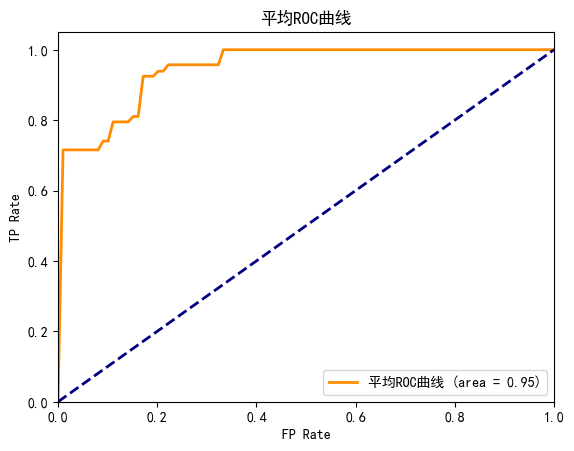

In [10]:
# 绘制平均ROC曲线
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label='平均ROC曲线 (area = %0.2f)' % mean_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('平均ROC曲线')
plt.legend(loc="lower right")
plt.show()